In [1]:
from IPython.display import display
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import msreport

sys.path.append("..")
from python_scripts import ticplot

In [2]:
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["font.family"] = "Arial"

## Define parameters, load qtables

In [3]:
# Define parameters
qtable_dir = "../qtable_data"
qtable_basenames = [
    "GFP-bead_Acetylation_peptides",
    "Strp-bead_Acetylation_peptides",
]
output_dir = "../plots/figure_2"

In [4]:
# Read qtable
qtables = {}
for qtable_basename in qtable_basenames: 
    qtable = msreport.Qtable.load(qtable_dir, qtable_basename)
    qtables[qtable_basename] = qtable

## Plot figures

In [5]:
fignames = {}
for qtable_basename in qtable_basenames:
    fignames[qtable_basename] = f"{qtable_basename}_abundance_plot.pdf"

In [6]:
def prepare_plotting_data(qtable, protein_id, sort_by, num_peptides):
    # Select target protein peptides
    data = qtable.data[qtable.data["Representative protein"] == protein_id]

    # Sort values according to reference experiment expression
    experiments = qtable.get_experiments()
    data = data.sort_values(sort_by, ascending=False).reset_index()

    # Select peptides to show
    mask = ~data[sort_by].isna()
    mask[num_peptides:] = False
    data = data[mask]

    return data

In [7]:
def generate_plot(figure, plotting_data, expression_columns, group_spacing):
    num_bars = len(plotting_data)
    bar_width = (1 - group_spacing) / num_bars
    ax = figure.axes[0]

    sns.set_style("white")
    xtick_labels = []
    xtick_positions = []
    max_y = np.power(2, plotting_data[expression_columns].max().max())
    
    for pos, expression_column in enumerate(expression_columns):
        y = np.power(2, plotting_data[expression_column])
        y = y / max_y * 100
        x = [pos + j * bar_width for j, _ in enumerate(y)]
        xtick_label = expression_column.split("Acetylation ")[1].replace("nm", " nm")
        xtick_labels.append(xtick_label)
        xtick_positions.append(np.mean(x))

        bars = ax.bar(
            x,
            y,
            width=bar_width,
            align="center",
            edgecolor="None",
            color=plotting_data["Colors light"],
            zorder=2,
        )
        ax.bar(
            x,
            y,
            width=bar_width,
            align="center",
            edgecolor=plotting_data["Colors"],
            color="None",
            lw=0.75,
            zorder=2,
        )
    
    # Add legend
    legend = ax.legend(
        bars,
        plotting_data["Peptide sequence"],
        handlelength=0.7,
        fontsize=6,
        loc="upper left",
        bbox_to_anchor=(0, -0.5),
        frameon=False,
        title="Peptide sequence",
        title_fontsize=8,
    )
    legend._legend_box.align = "left"

    # Ticks
    ax.set_xticks(xtick_positions, xtick_labels, fontsize=6, rotation=90)
    ax.tick_params(
        which="major",
        direction="out",
        length=1.5,
        width=0.3,
        colors="#333333",
        top=False,
        right=False,
        bottom=False,
        labelsize=6,
    )

    # Spines
    sns.despine(right=True, top=True, left=False, bottom=False)
    for spine in ax.spines.values():
        spine.set_color("#000000")
        spine.set_linewidth(0.5)

    # Axis labels
    ax.set_xlabel("S-NHS-ac treatment", fontsize=8)
    ax.set_ylabel("Peptide Intensity [%]", fontsize=8)

    # Adjust grind lines
    ax.yaxis.grid(
        which="both",
        linestyle="solid",
        lw=0.5,
        alpha=1,
        color="#DDDDDD",
    )
    ax.xaxis.grid(False, which="both")

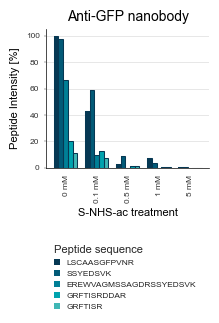

In [8]:
qtable_basename = "GFP-bead_Acetylation_peptides"
qtable = qtables[qtable_basename]
protein_id = "3OGO"
expression_columns = [f"Expression {exp}" for exp in qtable.get_experiments()]
sort_by = expression_columns[0]

num_peptides = 5
colors = ["#063853", "#025a77", "#007f96", "#00a3ae", "#40B7B5"]
title = "Anti-GFP nanobody"
group_spacing = 0.25

plotting_data = prepare_plotting_data(qtable, protein_id, sort_by, num_peptides)
plotting_data["Colors"] = [colors[0] for i in range(len(plotting_data))]
plotting_data["Colors light"] = colors[:len(plotting_data)]

fig, ax = plt.subplots(1, 1, figsize=(2.1, 1.8))
generate_plot(fig, plotting_data, expression_columns, group_spacing)
ax.set_title(title, fontsize=10)
xticks = []
for tick in ax.get_xticklabels():
    conc = float(tick.get_text().split("nM")[0]) / 1000
    xticks.append(f"{conc:g} mM")
ax.set_xticklabels(xticks)

figpath = os.path.join(output_dir, fignames[qtable_basename])
fig.savefig(figpath, dpi=300)

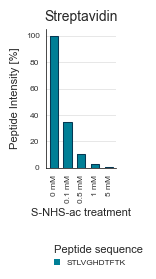

In [9]:
qtable_basename = "Strp-bead_Acetylation_peptides"
qtable = qtables[qtable_basename]
protein_id = "contam_P22629"
expression_columns = [f"Expression {exp}" for exp in qtable.get_experiments()]
sort_by = expression_columns[0]

num_peptides = 1
colors = ["#063853", "#025a77", "#007f96", "#00a3ae", "#40B7B5"]
title = "Streptavidin"
group_spacing = 0.4

plotting_data = prepare_plotting_data(qtable, protein_id, sort_by, num_peptides)
plotting_data["Colors"] = [colors[0] for i in range(len(plotting_data))]
plotting_data["Colors light"] = [colors[2] for i in range(len(plotting_data))]

fig, ax = plt.subplots(1, 1, figsize=(0.9, 1.8))
generate_plot(fig, plotting_data, expression_columns, group_spacing)
ax.set_title(title, fontsize=10)
xticks = []
for tick in ax.get_xticklabels():
    conc = float(tick.get_text().split("nM")[0]) / 1000
    xticks.append(f"{conc:g} mM")
ax.set_xticklabels(xticks)

figpath = os.path.join(output_dir, fignames[qtable_basename])
fig.savefig(figpath, dpi=300)